In [1]:
from exp.nb_Tesis import *

In [2]:
min_dim = 128 # 448

trainImagesFolderName = f'small_{min_dim}_ISIC_2019_Training_Input'
trainingGroundTruthFileName = 'ISIC_2019_Training_GroundTruth.csv'
testImagesFolderName = 'ISIC2018_Task3_Test_Input'
smallTestImagesFolderName = f'small_{min_dim}_ISIC2018_Task3_Test_Input'

trainingGroundTruthFileName = 'ISIC_2019_Training_GroundTruth.csv'


In [3]:
df = pd.read_csv(trainingGroundTruthFileName); print('# of images: ', len(df)); df.head()

# of images:  25331


,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
dfSingleLabel = pd.DataFrame({'image':df['image'] })
labelcols = df.columns[1:len(df.columns)]
dfSingleLabel['label'] = df[list(labelcols)].idxmax(axis='columns')
dfSingleLabel.head()

,image,label
0,ISIC_0000000,NV
1,ISIC_0000001,NV
2,ISIC_0000002,MEL
3,ISIC_0000003,NV
4,ISIC_0000004,MEL


In [5]:
labels_for_2018_live_challenge = ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC']

def get_label_for_image_name(image_name):
  return list(dfSingleLabel.loc[dfSingleLabel['image']==image_name].label)[0]
  
def get_label_for_image_path(image_path): return get_label_for_image_name(image_path.name[:-4])

#### Prune the dataset if needed

In [8]:
max_of_each = 30
classDict = {}
images = get_image_files(trainImagesFolderName)
newFolder = f'picked_{max_of_each}_{trainImagesFolderName}'
destFolder = Path(newFolder)
destFolder.mkdir(parents=True, exist_ok=True);

def prune_dataset(image,idx):
    label = get_label_for_image_path(image)
    if label in classDict: classDict[label] = classDict[label] + 1
    else: classDict[label] = 1
    
    if classDict[label] < max_of_each:
        !cp './'$image $destFolder'/'
#         print(classDict[label],max_of_each)

# parallel(partial(prune_dataset),images)
    

#### Remove warnings

In [9]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

In [19]:
torch.cuda.set_device(1)

## Load the dataset

In [20]:
random_seed(42,True)
tfms = get_transforms(flip_vert=True, max_rotate=180,max_zoom=1.3, max_lighting=.3,p_affine=1, max_warp=0)

data = ImageList.from_folder(destFolder)\
.split_by_rand_pct()\
.label_from_func(get_label_for_image_path)\
.transform(tfms,size=128)\
.databunch(bs=16)\
.normalize()

In [ ]:
data.show_batch(5)

In [21]:
train_count,valid_count = pd.value_counts(data.train_ds.y.items),pd.value_counts(data.valid_ds.y.items)
train_count.index,valid_count.index = [data.classes[i] for i in train_count.index],[data.classes[i] for i in valid_count.index]

print('train_count: \n',train_count,'\n\n','valid_count: \n', valid_count)
print('ratios:')
print(valid_count / train_count, '%')

train_count: 
 AK      285
MEL     284
SCC     283
BCC     282
BKL     272
NV      268
VASC    202
DF      188
dtype: int64 

 valid_count: 
 NV      80
BKL     76
BCC     66
SCC     65
MEL     64
AK      63
VASC    51
DF      51
dtype: int64
ratios:
AK      0.221053
BCC     0.234043
BKL     0.279412
DF      0.271277
MEL     0.225352
NV      0.298507
SCC     0.229682
VASC    0.252475
dtype: float64 %


# Experiment: DenseNet201 vs EfficientNet-b0 vs EfficientNet-b3

First let's see the difference between efficientnet and densenet201 all things being equal

In [45]:
def get_class_weights():
    weighted_classes = [{c: max(train_count) / train_count[c]} for c in data.classes];
    print(weighted_classes)
    formatted_weights = [w[c] for c,w in zip(data.classes, weighted_classes) ] 
    class_weights=torch.FloatTensor(formatted_weights).cuda()
    return class_weights

def train_learner(learner,name):
    learner.loss_func = CrossEntropyFlat(weight = get_class_weights())
    random_seed(7,True)
    max_lr = slice(1e-3,1e-2)
    wd = 1e-4
    log_name = f'2019_imgsz_{learner.data.valid_ds[0][0].shape[1]}_{name}'
    print("Saving log on: ",log_name)
    learner.fit_one_cycle(8,max_lr=1e-3,wd=wd, callbacks = [
        SaveModelCallback(learn=learner,name=log_name),
        CSVLogger(learn=learner,filename=model_name)
    #     ReduceLROnPlateauCallback(learn=learn)
    ])

## Efficientnet-b0

In [46]:
from efficientnet_pytorch import EfficientNet

model_name = 'efficientnet-b0'
model_b0 = EfficientNet.from_pretrained(model_name)
model_b0._fc = nn.Linear(1280, data.c) # si es b0 poner aca 1280, si es b3 poner 1536

learn_b0 = Learner(data,model_b0, 
                    metrics=[error_rate,accuracy,AUROC()],
                    callback_fns=[
                            ShowGraph,
                            ActivationStats,
                                  ]               )

learn_b0.summary()

Loaded pretrained weights for efficientnet-b0


EfficientNet
Layer (type)         Output Shape         Param #    Trainable 
ZeroPad2d            [3, 129, 129]        0          False     
______________________________________________________________________
BatchNorm2d          [32, 64, 64]         64         True      
______________________________________________________________________
ZeroPad2d            [32, 66, 66]         0          False     
______________________________________________________________________
BatchNorm2d          [32, 64, 64]         64         True      
______________________________________________________________________
Identity             [32, 1, 1]           0          False     
______________________________________________________________________
Identity             [8, 1, 1]            0          False     
______________________________________________________________________
Identity             [32, 64, 64]         0          False     
_________________________________________________

[{'AK': 1.0}, {'BCC': 1.0106382978723405}, {'BKL': 1.0477941176470589}, {'DF': 1.5159574468085106}, {'MEL': 1.0035211267605635}, {'NV': 1.0634328358208955}, {'SCC': 1.0070671378091873}, {'VASC': 1.4108910891089108}]
[1.0, 1.0106382978723405, 1.0477941176470589, 1.5159574468085106, 1.0035211267605635, 1.0634328358208955, 1.0070671378091873, 1.4108910891089108]


epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.818445,1.718047,0.666667,0.333333,0.519091,00:18
1,1.539726,1.471600,0.577519,0.422481,0.581077,00:17
2,1.435312,1.440250,0.525194,0.474806,0.400875,00:17
3,1.302367,1.417880,0.500000,0.500000,0.524613,00:18
4,1.143010,1.257084,0.432171,0.567829,0.630471,00:17
5,0.984225,1.149337,0.403101,0.596899,0.537811,00:17
6,0.814959,1.109193,0.377907,0.622093,0.529764,00:17
7,0.768689,1.076705,0.372093,0.627907,0.536397,00:18


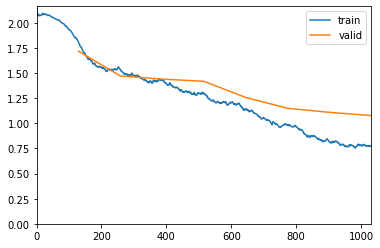

Better model found at epoch 0 with valid_loss value: 1.7180471420288086.
Better model found at epoch 1 with valid_loss value: 1.471599817276001.
Better model found at epoch 2 with valid_loss value: 1.4402501583099365.
Better model found at epoch 3 with valid_loss value: 1.4178804159164429.
Better model found at epoch 4 with valid_loss value: 1.2570843696594238.
Better model found at epoch 5 with valid_loss value: 1.149336814880371.
Better model found at epoch 6 with valid_loss value: 1.1091934442520142.
Better model found at epoch 7 with valid_loss value: 1.0767048597335815.


In [48]:
train_learner(learn_b0,'EfficientNet-b0')

## Densenet

In [50]:
dense_learn = cnn_learner(data,models.densenet201, 
                    metrics=[error_rate,accuracy,AUROC()],
                    callback_fns=[
                            ShowGraph,
                            ActivationStats,
                                  ]               )

dense_learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 64, 64]         9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 64, 64]         128        True      
______________________________________________________________________
ReLU                 [64, 64, 64]         0          False     
______________________________________________________________________
MaxPool2d            [64, 32, 32]         0          False     
______________________________________________________________________
BatchNorm2d          [64, 32, 32]         128        True      
______________________________________________________________________
ReLU                 [64, 32, 32]         0          False     
______________________________________________________________________
Conv2d               [128, 32, 32]        8,192      False     
___________________________________________________

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,2.665530,1.947946,0.598837,0.401163,0.527677,00:45
1,2.229905,1.877940,0.571705,0.428295,0.527677,00:46
2,1.916193,1.491648,0.527132,0.472868,0.536229,00:45
3,1.673306,1.731876,0.529070,0.470930,0.537912,00:45
4,1.487908,1.459155,0.472868,0.527132,0.519562,00:44
5,1.314788,1.266923,0.441860,0.558140,0.474646,00:45
6,1.131491,1.233500,0.439922,0.560078,0.470640,00:46
7,1.058309,1.215065,0.436047,0.563953,0.457845,00:46


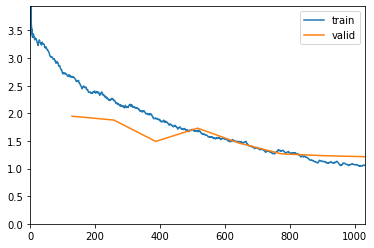

Better model found at epoch 0 with valid_loss value: 1.9479464292526245.
Better model found at epoch 1 with valid_loss value: 1.8779397010803223.
Better model found at epoch 2 with valid_loss value: 1.4916479587554932.
Better model found at epoch 4 with valid_loss value: 1.4591550827026367.
Better model found at epoch 5 with valid_loss value: 1.2669233083724976.
Better model found at epoch 6 with valid_loss value: 1.2335002422332764.
Better model found at epoch 7 with valid_loss value: 1.2150650024414062.


In [26]:
train_learner(dense_learn,'DenseNet-201')

## EfficientNet-b3

In [31]:
from efficientnet_pytorch import EfficientNet

model_name = 'efficientnet-b3'
model_b3 = EfficientNet.from_pretrained(model_name)
model_b3._fc = nn.Linear(1536, data.c) # si es b0 poner aca 1280, si es b3 poner 1536

learn_b3 = Learner(data,model_b3, 
                    metrics=[error_rate,accuracy,AUROC()],
                    callback_fns=[
                            ShowGraph,
                            ActivationStats,
                                  ]               )

learn_b3.summary()

Loaded pretrained weights for efficientnet-b3


EfficientNet
Layer (type)         Output Shape         Param #    Trainable 
ZeroPad2d            [3, 129, 129]        0          False     
______________________________________________________________________
BatchNorm2d          [40, 64, 64]         80         True      
______________________________________________________________________
ZeroPad2d            [40, 66, 66]         0          False     
______________________________________________________________________
BatchNorm2d          [40, 64, 64]         80         True      
______________________________________________________________________
Identity             [40, 1, 1]           0          False     
______________________________________________________________________
Identity             [10, 1, 1]           0          False     
______________________________________________________________________
Identity             [40, 64, 64]         0          False     
_________________________________________________

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.840573,1.688768,0.641473,0.358527,0.533232,00:26
1,1.615813,1.886212,0.625969,0.374031,0.548586,00:28
2,1.536669,1.661582,0.600775,0.399225,0.435488,00:28
3,1.436897,1.913213,0.548450,0.451550,0.557508,00:27
4,1.256224,1.445672,0.461240,0.538760,0.451010,00:27
5,1.118578,1.271640,0.451550,0.548450,0.390673,00:26
6,0.916247,1.187197,0.406977,0.593023,0.518350,00:27
7,0.843419,1.153786,0.405039,0.594961,0.503434,00:27


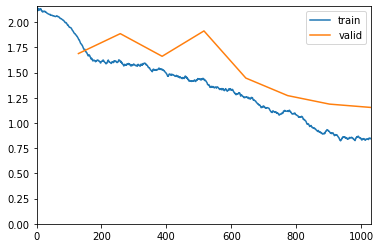

Better model found at epoch 0 with valid_loss value: 1.6887680292129517.
Better model found at epoch 2 with valid_loss value: 1.6615818738937378.
Better model found at epoch 4 with valid_loss value: 1.4456721544265747.
Better model found at epoch 5 with valid_loss value: 1.2716400623321533.
Better model found at epoch 6 with valid_loss value: 1.187197208404541.
Better model found at epoch 7 with valid_loss value: 1.1537859439849854.


In [32]:
train_learner(learn_b3,'EfficientNet-b3')

# Conclusion

It seems that densenet201 performs worse than efficientnet-b0 on 128 sized images. Not only it trains slower, but it achieves worse performance. Moreso, EfficientNet-b3 also seems to perform worse than efficientNet-b0. This is counterintuitive and may be due to image size or number of training epochs

# Experiment: Push EfficientNet-b0 in 40 training epochs

# Other

# Test

In [ ]:
learn.export('2018_new.pkl')

In [ ]:
learn2 = load_learner(path=trainImagesFolderName, file="2018_new.pkl", 
                     test=ImageList.from_folder(smallTestImagesFolderName),
                     )

In [ ]:
preds, y = learn2.TTA(ds_type=DatasetType.Test, beta=0.4, scale=1.35)

In [ ]:
arrOfPreds = [learn2.data.classes[pred.argmax().item()] for pred in preds];arrOfPreds[0:5]

In [ ]:

allCategories = learn2.data.classes
cols = ['image'] + allCategories


predictions = []
for idx, filePath in enumerate(learn2.data.test_ds.items):
  row = {}
  current_pred = preds[idx]
  max_confidence = current_pred.max().item()
  row['image'] = filePath.name.replace('.jpg','')
  for idx2, cat in enumerate(allCategories):
    row[cat] = current_pred[idx2].item()
  
  predictions.append(row)

predictionsDf = pd.DataFrame(predictions, columns=cols);
  
  

In [ ]:
len(predictionsDf)
predictionsDf = predictionsDf.rename(columns={'AK':'AKIEC'})
predictionsDf2 = predictionsDf.drop(columns=['SCC'])
predictionsDf2.head()

In [ ]:
predictions_csv_path = 'predictionsTest2019.csv'
predictionsDf2.to_csv(predictions_csv_path, index=False)